In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
from mtcnn.mtcnn import MTCNN
import matplotlib.patches as patches
import random
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output
import imageio
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [12]:
img_size = 64
batch_size = 64

def scaling(x):
    x = (x-127.5)/127.5 
    return x
    

datagen = ImageDataGenerator(preprocessing_function=scaling)

data_generator = datagen.flow_from_directory(directory='/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets',
                                        target_size=(img_size,img_size),
                                        class_mode=None,
                                        batch_size=batch_size,
                                        classes=['images'],
                                        shuffle=True)

samples = data_generator.samples

Found 46371 images belonging to 1 classes.


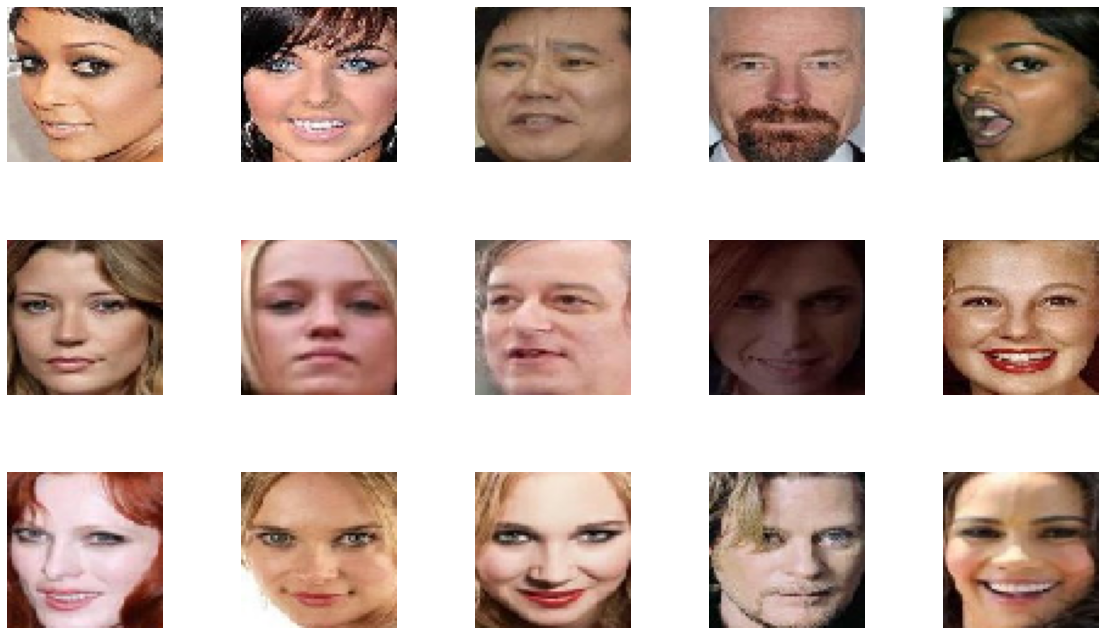

In [13]:
images = data_generator.__next__()

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow((images[i]+1)/2)
    plt.axis('off')

In [33]:
discriminator = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Conv2D(32, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(64, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(128, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_42 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 128)       

In [34]:
latent_dim = 256
generator = Sequential(
    [
        Input(shape=(latent_dim,)),
        Dense(4 * 4 * 256),
        Reshape((4, 4, 256)),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4096)              1052672   
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 256)         1048832   
_________________________________________________________________
batch_normalization_46 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 16, 128)       51

Epoch:  0


100%|██████████| 725/725 [01:59<00:00,  6.08it/s]


Epoch: 0 Generator Loss: 3.1226131916046143 Discriminator Loss: 0.31388238072395325


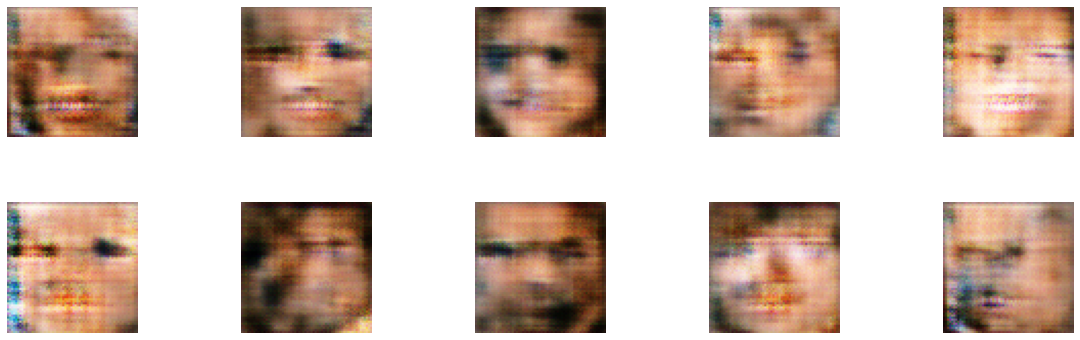

Epoch:  1


100%|██████████| 725/725 [01:49<00:00,  6.62it/s]


Epoch: 1 Generator Loss: 2.6371004581451416 Discriminator Loss: 0.3699697256088257
Epoch:  2


100%|██████████| 725/725 [01:49<00:00,  6.62it/s]


Epoch: 2 Generator Loss: 2.488109827041626 Discriminator Loss: 0.38708797097206116
Epoch:  3


100%|██████████| 725/725 [01:49<00:00,  6.60it/s]


Epoch: 3 Generator Loss: 2.372231960296631 Discriminator Loss: 0.4037395715713501
Epoch:  4


100%|██████████| 725/725 [01:48<00:00,  6.68it/s]


Epoch: 4 Generator Loss: 2.26286244392395 Discriminator Loss: 0.42086759209632874
Epoch:  5


100%|██████████| 725/725 [01:48<00:00,  6.68it/s]


Epoch: 5 Generator Loss: 2.1759631633758545 Discriminator Loss: 0.4349178373813629


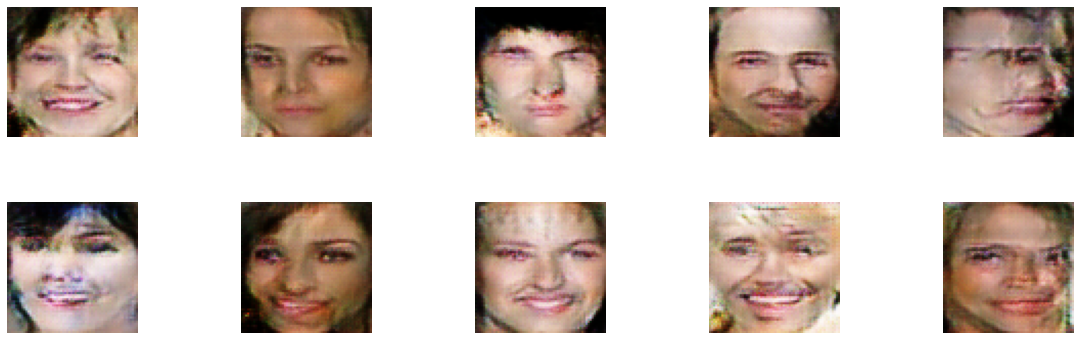

Epoch:  6


100%|██████████| 725/725 [01:49<00:00,  6.62it/s]


Epoch: 6 Generator Loss: 2.102506637573242 Discriminator Loss: 0.4464176595211029
Epoch:  7


100%|██████████| 725/725 [01:50<00:00,  6.57it/s]


Epoch: 7 Generator Loss: 2.045837879180908 Discriminator Loss: 0.45527511835098267
Epoch:  8


100%|██████████| 725/725 [01:49<00:00,  6.64it/s]


Epoch: 8 Generator Loss: 2.003594160079956 Discriminator Loss: 0.4617498815059662
Epoch:  9


100%|██████████| 725/725 [01:49<00:00,  6.65it/s]


Epoch: 9 Generator Loss: 1.968887448310852 Discriminator Loss: 0.46715033054351807
Epoch:  10


100%|██████████| 725/725 [01:49<00:00,  6.60it/s]


Epoch: 10 Generator Loss: 1.9411287307739258 Discriminator Loss: 0.4711126983165741


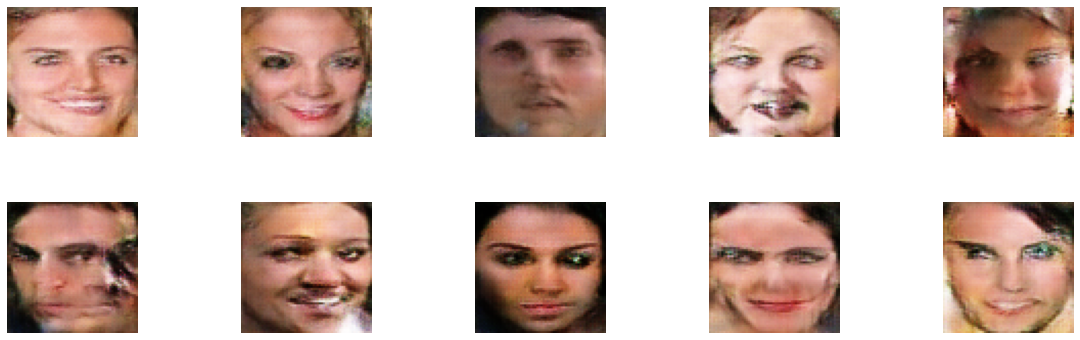

Epoch:  11


100%|██████████| 725/725 [01:49<00:00,  6.59it/s]


Epoch: 11 Generator Loss: 1.917331576347351 Discriminator Loss: 0.47424036264419556
Epoch:  12


100%|██████████| 725/725 [01:49<00:00,  6.64it/s]


Epoch: 12 Generator Loss: 1.896815299987793 Discriminator Loss: 0.4769722521305084
Epoch:  13


100%|██████████| 725/725 [01:49<00:00,  6.60it/s]


Epoch: 13 Generator Loss: 1.8805410861968994 Discriminator Loss: 0.4789160192012787
Epoch:  14


100%|██████████| 725/725 [01:50<00:00,  6.57it/s]


Epoch: 14 Generator Loss: 1.8674793243408203 Discriminator Loss: 0.48043960332870483
Epoch:  15


100%|██████████| 725/725 [01:50<00:00,  6.56it/s]


Epoch: 15 Generator Loss: 1.8565239906311035 Discriminator Loss: 0.48141592741012573


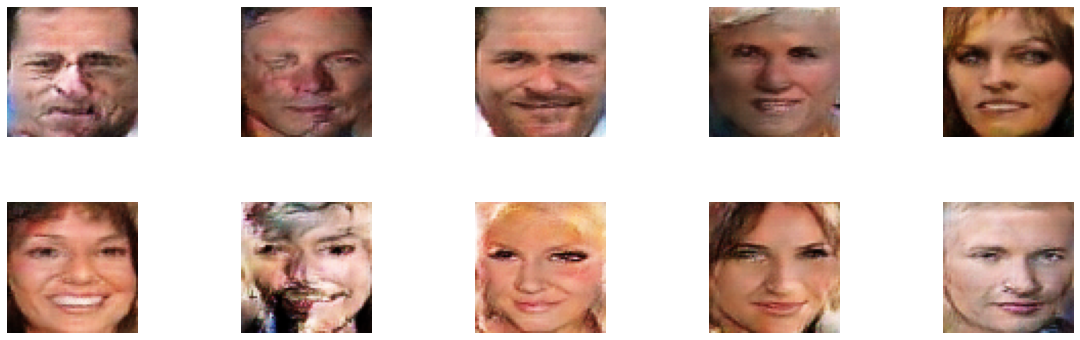

Epoch:  16


100%|██████████| 725/725 [01:53<00:00,  6.38it/s]


Epoch: 16 Generator Loss: 1.848349690437317 Discriminator Loss: 0.4820155203342438
Epoch:  17


100%|██████████| 725/725 [01:52<00:00,  6.45it/s]


Epoch: 17 Generator Loss: 1.8432668447494507 Discriminator Loss: 0.4820677936077118
Epoch:  18


100%|██████████| 725/725 [01:49<00:00,  6.60it/s]


Epoch: 18 Generator Loss: 1.8410089015960693 Discriminator Loss: 0.4815230965614319
Epoch:  19


100%|██████████| 725/725 [01:49<00:00,  6.61it/s]


Epoch: 19 Generator Loss: 1.840556263923645 Discriminator Loss: 0.4807415008544922
Epoch:  20


100%|██████████| 725/725 [01:50<00:00,  6.55it/s]


Epoch: 20 Generator Loss: 1.8372571468353271 Discriminator Loss: 0.48095080256462097


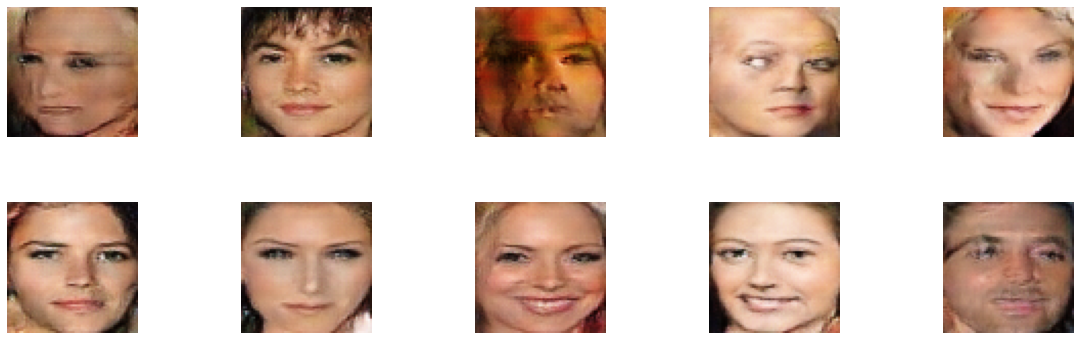

Epoch:  21


100%|██████████| 725/725 [01:50<00:00,  6.56it/s]


Epoch: 21 Generator Loss: 1.8383206129074097 Discriminator Loss: 0.47981327772140503
Epoch:  22


100%|██████████| 725/725 [01:51<00:00,  6.48it/s]


Epoch: 22 Generator Loss: 1.8403780460357666 Discriminator Loss: 0.4784213900566101
Epoch:  23


100%|██████████| 725/725 [01:54<00:00,  6.36it/s]


Epoch: 23 Generator Loss: 1.844987392425537 Discriminator Loss: 0.47689592838287354
Epoch:  24


100%|██████████| 725/725 [01:54<00:00,  6.36it/s]


Epoch: 24 Generator Loss: 1.8506498336791992 Discriminator Loss: 0.4750806987285614
Epoch:  25


100%|██████████| 725/725 [01:55<00:00,  6.27it/s]


Epoch: 25 Generator Loss: 1.85868239402771 Discriminator Loss: 0.4730689525604248


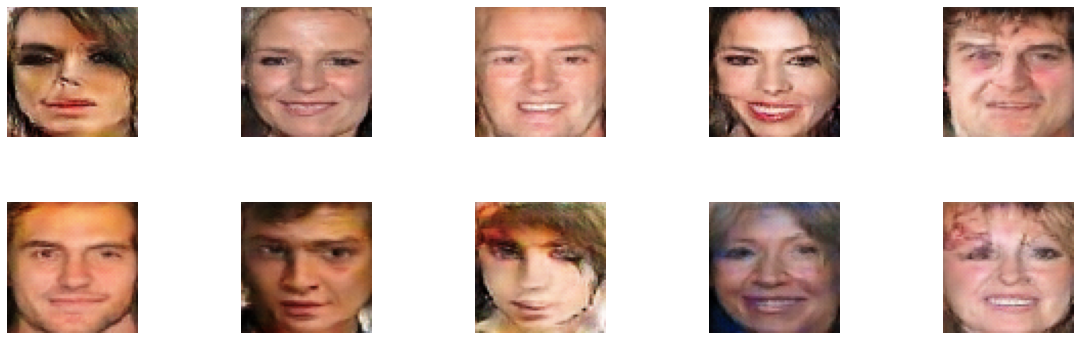

Epoch:  26


100%|██████████| 725/725 [01:56<00:00,  6.20it/s]


Epoch: 26 Generator Loss: 1.86795175075531 Discriminator Loss: 0.47100719809532166
Epoch:  27


100%|██████████| 725/725 [01:58<00:00,  6.12it/s]


Epoch: 27 Generator Loss: 1.8789000511169434 Discriminator Loss: 0.46858784556388855
Epoch:  28


100%|██████████| 725/725 [01:55<00:00,  6.29it/s]


Epoch: 28 Generator Loss: 1.8908731937408447 Discriminator Loss: 0.46604716777801514
Epoch:  29


100%|██████████| 725/725 [01:51<00:00,  6.48it/s]


Epoch: 29 Generator Loss: 1.9043341875076294 Discriminator Loss: 0.4632621705532074
Epoch:  30


100%|██████████| 725/725 [01:51<00:00,  6.48it/s]


Epoch: 30 Generator Loss: 1.9187588691711426 Discriminator Loss: 0.4605235755443573


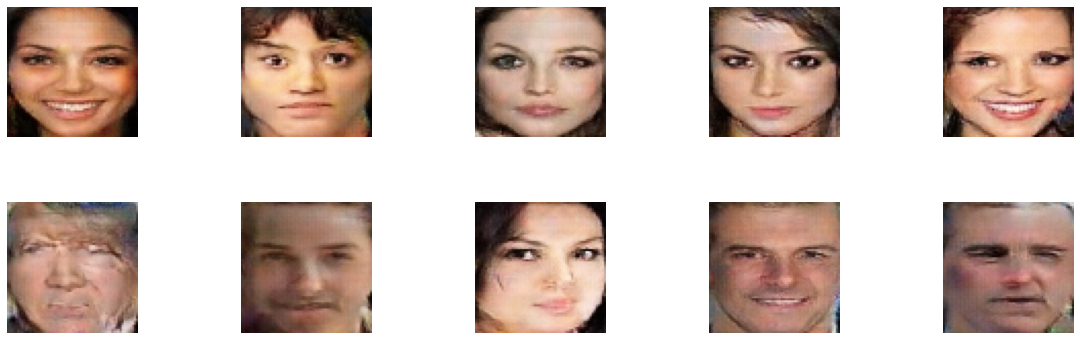

In [35]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
dis_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
epochs=30
steps_per_epoch = int(-(samples/-batch_size))

disc_losses = []
gen_losses = []

for epoch in range(epochs+1):
    print("Epoch: ",epoch)
    for idx, (real) in enumerate(tqdm(data_generator)):
        if idx > steps_per_epoch:
            break
        
        batch_size = real.shape[0]
        random_latent_vectors = tf.random.normal(shape = (batch_size, latent_dim))
        fake = generator(random_latent_vectors)

        with tf.GradientTape() as d_tape:
            loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
            loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake)/2
            disc_losses.append(loss_disc)

        grads = d_tape.gradient(loss_disc, discriminator.trainable_weights)
        dis_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        with tf.GradientTape() as g_tape:
            fake = generator(random_latent_vectors)
            output = discriminator(fake)
            loss_gen = loss_fn(tf.ones(batch_size, 1), output)
            gen_losses.append(loss_gen)

        grads = g_tape.gradient(loss_gen, generator.trainable_weights)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    
    mean_disc_loss = sum(disc_losses)/len(disc_losses)
    mean_gen_loss = sum(gen_losses)/len(gen_losses)
    
    print(f"Epoch: {epoch} Generator Loss: {mean_gen_loss} Discriminator Loss: {mean_disc_loss}")
    data_generator.on_epoch_end()
    
    if epoch % 5 == 0:
        random_latent_vectors = tf.random.normal(shape = (10, latent_dim))
        fake = generator(random_latent_vectors)
        generated_images = fake.numpy()
        plt.figure(figsize = (20 , 6))
        for i in range(10):
            plt.subplot(2 , 5, i+1)
            plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
            image = generated_images[i]
            plt.imshow((image+1)/2)
            plt.axis('off')
        plt.show()

In [43]:
random_latent_vectors = tf.random.normal(shape = (30, latent_dim))
fake = generator.predict(random_latent_vectors)

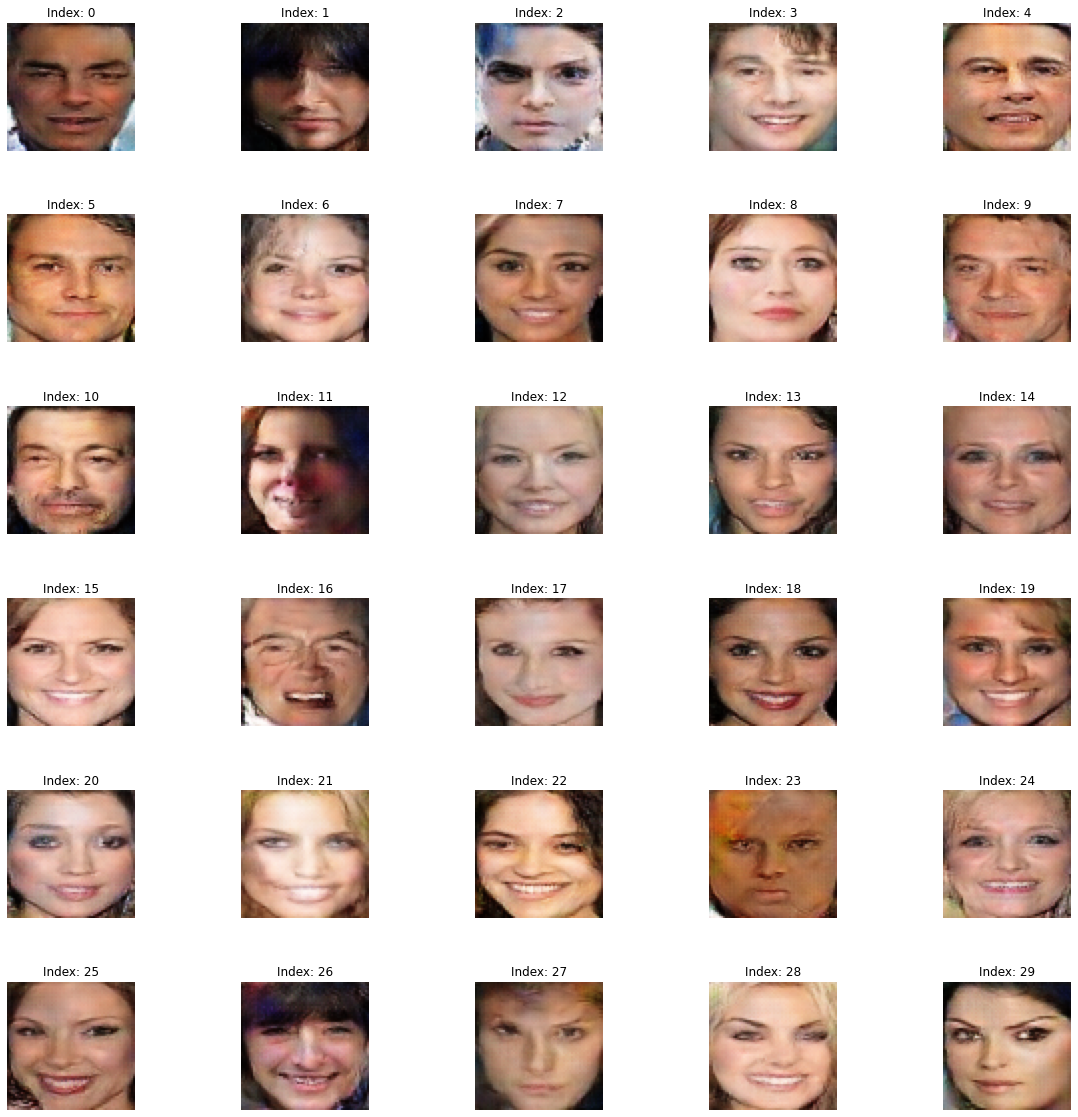

In [44]:
plt.figure(figsize = (20 , 20))
for i in range(30):
    plt.subplot(6 , 5, i+1)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow((fake[i]+1)/2)
    plt.title(f"Index: {i}")
    plt.axis('off')
plt.show()

In [52]:
smiling_woman = (random_latent_vectors[18] + random_latent_vectors[21] + random_latent_vectors[22]) / 3
neutral_woman = (random_latent_vectors[8] + random_latent_vectors[17] + random_latent_vectors[29]) / 3
neutral_man = (random_latent_vectors[5] + random_latent_vectors[9] + random_latent_vectors[10]) / 3

smiling_man = smiling_woman - neutral_woman + neutral_man

In [53]:
sample1 = generator.predict(np.expand_dims(smiling_woman,axis=0))
sample2 = generator.predict(np.expand_dims(neutral_woman,axis=0))
sample3 = generator.predict(np.expand_dims(neutral_man,axis=0))
result = generator.predict(np.expand_dims(smiling_man,axis=0))

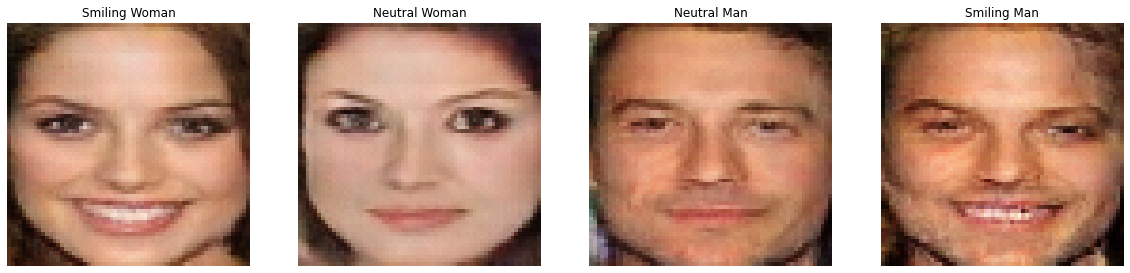

In [58]:
plt.figure(figsize = (20 , 6))
plt.subplot(1,4,1)
plt.imshow((sample1[0]+1)/2)
plt.title("Smiling Woman")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow((sample2[0]+1)/2)
plt.title("Neutral Woman")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow((sample3[0]+1)/2)
plt.title("Neutral Man")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow((result[0]+1)/2)
plt.title("Smiling Man")
plt.axis('off')
plt.show()